In [1]:
!pip install transformers datasets seaborn nltk

!pip install openai
!pip install requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00


In [14]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import openai
from openai import OpenAI

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("No GPU available, using the CPU instead.")

No GPU available, using the CPU instead.


In [6]:
# Load your dataset
file_path = 'text.csv'
data = pd.read_csv(file_path)


In [7]:
data

,id,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...,...
416804,416804,i feel like telling these horny devils to find...,2
416805,416805,i began to realize that when i was feeling agi...,3
416806,416806,i feel very curious be why previous early dawn...,5
416807,416807,i feel that becuase of the tyranical nature of...,3


In [8]:
# 0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Suprise'

# Mapping of integer labels to emotion names
emotion_mapping = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

# Convert integer labels to emotion names
data['emotion'] = data['label'].map(emotion_mapping)

print(data)

            id                                               text  label  \
0            0      i just feel really helpless and heavy hearted      4   
1            1  ive enjoyed being able to slouch about relax a...      0   
2            2  i gave up my internship with the dmrg and am f...      4   
3            3                         i dont know i feel so lost      0   
4            4  i am a kindergarten teacher and i am thoroughl...      4   
...        ...                                                ...    ...   
416804  416804  i feel like telling these horny devils to find...      2   
416805  416805  i began to realize that when i was feeling agi...      3   
416806  416806  i feel very curious be why previous early dawn...      5   
416807  416807  i feel that becuase of the tyranical nature of...      3   
416808  416808  i think that after i had spent some time inves...      5   

         emotion  
0           Fear  
1        Sadness  
2           Fear  
3        Sa

In [16]:
df = pd.DataFrame(data)

print(df)

# Function to classify emotion using GPT
def classify_emotion(text):
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {
                    "role": "user",
                    "content": f"Classify the emotion in the following text. One word only. only valid answers are Sadness, Joy, Love, Anger, Fear, Suprise. the text is:{text}",
                },
            ],
            max_tokens=300
        )

        return response.choices[0].message.content
    except Exception as e:
        print(f"An error occurred: {e}")
        return "Error"

client = OpenAI(
    api_key=''
)

# Initialize an empty list to store the emotions
emotions = []

if len(df) > 1000:
    df = df.head(1000)

# Loop through each row in the DataFrame
for index, row in df.iterrows():
    # Classify the emotion of the text in each row
    emotion = classify_emotion(row['text'])
    emotions.append(emotion)
    print(f"Processed {index + 1}/{len(df)}: {emotion}")

# Add the classified emotions as a new column in the DataFrame
df['emotion_GPT'] = emotions

print(df)

            id                                               text  label  \
0            0      i just feel really helpless and heavy hearted      4   
1            1  ive enjoyed being able to slouch about relax a...      0   
2            2  i gave up my internship with the dmrg and am f...      4   
3            3                         i dont know i feel so lost      0   
4            4  i am a kindergarten teacher and i am thoroughl...      4   
...        ...                                                ...    ...   
416804  416804  i feel like telling these horny devils to find...      2   
416805  416805  i began to realize that when i was feeling agi...      3   
416806  416806  i feel very curious be why previous early dawn...      5   
416807  416807  i feel that becuase of the tyranical nature of...      3   
416808  416808  i think that after i had spent some time inves...      5   

         emotion  
0           Fear  
1        Sadness  
2           Fear  
3        Sa

In [17]:
import pandas as pd

# Assuming df is your DataFrame that already includes the 'emotion_GPT' column

# List of valid emotions
valid_emotions = ["Sadness", "Joy", "Love", "Anger", "Fear", "Surprise"]

# Function to replace invalid emotions with 'Other'
def replace_invalid_emotions(emotion):
    if emotion not in valid_emotions:
        return "Other"
    return emotion

# Apply the function to the 'emotion_GPT' column
df['emotion_GPT_cleaned'] = df['emotion_GPT'].apply(replace_invalid_emotions)

print(df)


      id                                               text  label  emotion  \
0      0      i just feel really helpless and heavy hearted      4     Fear   
1      1  ive enjoyed being able to slouch about relax a...      0  Sadness   
2      2  i gave up my internship with the dmrg and am f...      4     Fear   
3      3                         i dont know i feel so lost      0  Sadness   
4      4  i am a kindergarten teacher and i am thoroughl...      4     Fear   
..   ...                                                ...    ...      ...   
995  995  i would have stuck around but i was feeling so...      1      Joy   
996  996  i feel like im her stubborn client though i al...      3    Anger   
997  997  i just get caught up in the fun of the night a...      0  Sadness   
998  998     i can not help but feel a little bit resentful      3    Anger   
999  999  i feel totally foolish for trying to talk her ...      0  Sadness   

    emotion_GPT emotion_GPT_cleaned  
0       Sadne

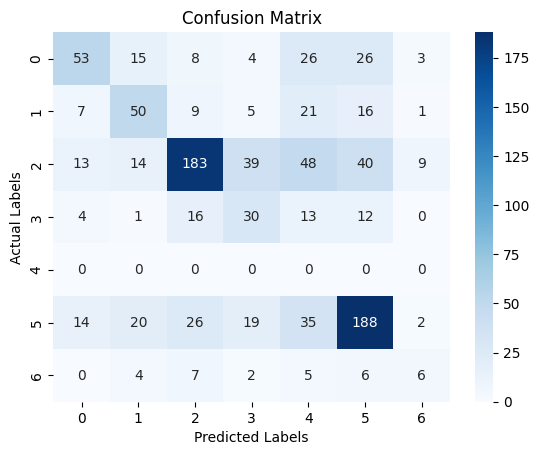

              precision    recall  f1-score   support

       Anger       0.58      0.39      0.47       135
        Fear       0.48      0.46      0.47       109
         Joy       0.73      0.53      0.62       346
        Love       0.30      0.39      0.34        76
       Other       0.00      0.00      0.00         0
     Sadness       0.65      0.62      0.64       304
    Surprise       0.29      0.20      0.24        30

    accuracy                           0.51      1000
   macro avg       0.43      0.37      0.40      1000
weighted avg       0.62      0.51      0.55      1000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
from sklearn.metrics import confusion_matrix, classification_report

# Compute the confusion matrix
conf_matrix = confusion_matrix(df['emotion'], df['emotion_GPT_cleaned'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Calculate classification metrics
print(classification_report(df['emotion'], df['emotion_GPT_cleaned']))